# Dataset Creation of "hard" CUDA kernels to query 

This notebook grabs the profiling data for the CUDA kernels that we've identified as being "hard" for our prediction pipeline to classify.

In [243]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
from tqdm import tqdm
import csv
import textwrap

In [244]:
# Load the classification results
with open('manually_classified_CUDA_kernels_manually-edited.json', 'r') as f:
    data = json.load(f)

In [245]:
# Parse the loaded JSON (in variable `data`) into a DataFrame of manual classifications
# Expected JSON structure:
# {
#   "categories": [...],
#   "classifications": { "target|filepath|idx": { categoryFlagName: bool, ... }, ... }
# }

categories = data.get('categories', [])
classifications = data.get('classifications', {})

records = []
for composite_key, flags in classifications.items():
    # Split the composite key into its components (robust to extra '|')
    parts = composite_key.split('|')
    target_name = parts[0] if len(parts) > 0 else None
    file_path = parts[1] if len(parts) > 1 else None
    kernel_idx_raw = parts[2] if len(parts) > 2 else None
    try:
        kernel_idx = int(kernel_idx_raw) if kernel_idx_raw is not None else None
    except ValueError:
        kernel_idx = kernel_idx_raw  # leave as string if not int

    row = {
        'targetName': target_name,
        'filepath': file_path,
        'kernel_index': kernel_idx,
    }
    # Ensure all categories appear (even if missing in a particular entry)
    for cat in categories:
        row[cat] = flags.get(cat, None)

    records.append(row)

manual_df = pd.DataFrame(records)

# Create normalized / pythonic boolean columns for easier filtering
import re

def normalize(col: str) -> str:
    # remove leading numeric labels like '1: '
    col_wo_prefix = re.sub(r'^\d+:\s*', '', col)
    return (col_wo_prefix.lower()
            .replace(' ', '_')
            .replace('-', '_')
            .replace('/', '_')
            .replace('__', '_'))

normalized_map = {cat: normalize(cat) for cat in categories}
normalized_map.pop('9: Missing Some Code')

for original, norm in normalized_map.items():
    if original in manual_df.columns:
        manual_df[norm] = manual_df[original].astype(bool)

# Reorder columns: identifiers first, then original category names, then normalized names
original_cat_cols = categories
#normalized_cols = [normalized_map[c] for c in categories]
normalized_cols = list(normalized_map.values())
ordered_cols = ['targetName', 'filepath', 'kernel_index'] + original_cat_cols + normalized_cols
manual_df = manual_df[ordered_cols]

print(f"Parsed {manual_df.shape[0]} classified kernels with {len(categories)} feature flags.")
manual_df.head()

Parsed 717 classified kernels with 9 feature flags.


,targetName,filepath,kernel_index,1: Has Warp Divergence,2: Has Data-Dependent Warp Divergence,3: Has FLOP Division,4: Calls EXTERNAL or LIB function,5: Calls DEVICE function,6: Calls special math function,7: Has Common Subexpression,8: Has Recursion,9: Missing Some Code,has_warp_divergence,has_data_dependent_warp_divergence,has_flop_division,calls_external_or_lib_function,calls_device_function,calls_special_math_function,has_common_subexpression,has_recursion
0,aligned-types-cuda,/Users/gbolet/hecbench-roofline/src/aligned-ty...,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False
2,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False
4,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False


In [246]:
# make a combination column for the binary features

manual_df['combination'] = manual_df[normalized_cols].apply(
    lambda row: ''.join(row.astype(int).astype(str)), axis=1)


test = manual_df[manual_df['combination'] == '10000000']
print(test.shape)

assert manual_df[manual_df['combination'] == '10000000'].shape[0] == 156, "Sanity check failed!"

(156, 21)


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27646/1984192966.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




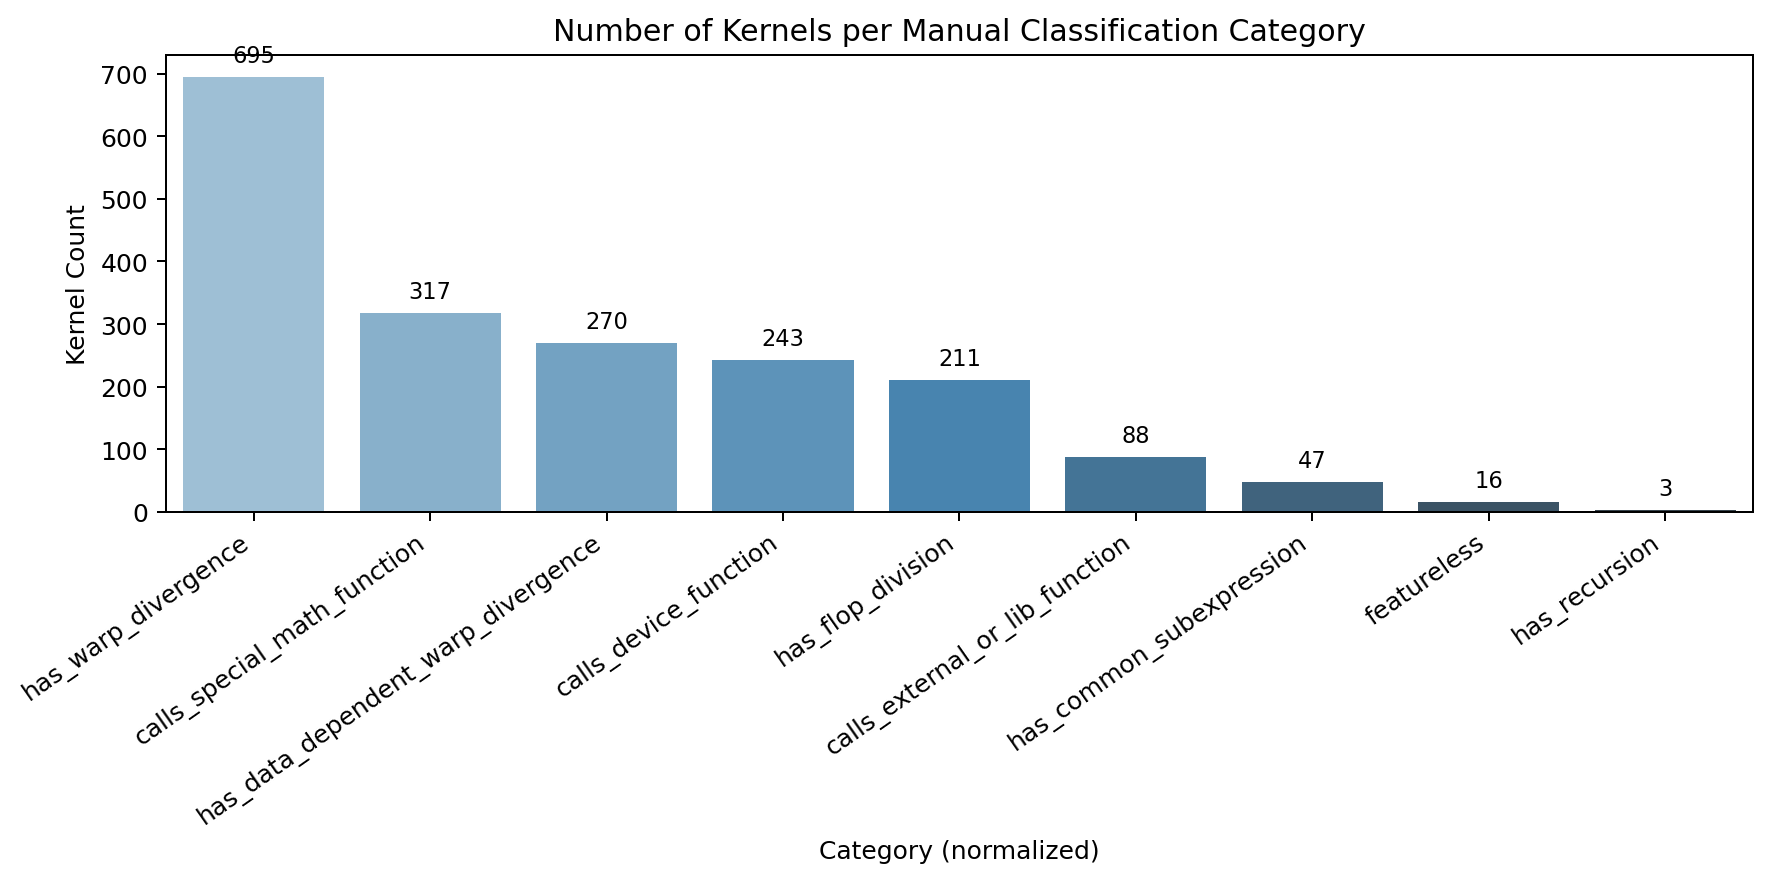

,feature,count
0,has_warp_divergence,695
1,calls_special_math_function,317
2,has_data_dependent_warp_divergence,270
3,calls_device_function,243
4,has_flop_division,211


In [247]:
# Barplot: count of codes per (normalized) category (+ featureless case)
# Use the normalized boolean columns created earlier (normalized_cols)

assert 'manual_df' in globals(), "manual_df not found. Run previous cell first."
assert 'normalized_cols' in globals(), "normalized_cols list not found."

# Ensure columns exist
existing_norm_cols = [c for c in normalized_cols if c in manual_df.columns]

# Sum booleans (True counts) per feature
feature_counts_df = (manual_df[existing_norm_cols]
                     .astype(int)
                     .sum()
                     .reset_index())
feature_counts_df.columns = ['feature', 'count']

# Add the featureless category: rows where all normalized features are False
featureless_count = (manual_df[existing_norm_cols].astype(int).sum(axis=1) == 0).sum()
feature_counts_df = pd.concat([
    feature_counts_df,
    pd.DataFrame([{'feature': 'featureless', 'count': featureless_count}])
], ignore_index=True)

# Order by count descending (featureless included)
feature_counts_df = feature_counts_df.sort_values('count', ascending=False, ignore_index=True)

plt.figure(figsize=(10, 5), dpi=180)
ax = sns.barplot(x='feature', y='count', data=feature_counts_df, palette='Blues_d')
plt.title('Number of Kernels per Manual Classification Category')
plt.xlabel('Category (normalized)')
plt.ylabel('Kernel Count')
plt.xticks(rotation=35, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0,4), textcoords='offset points')

plt.tight_layout()
plt.show()

feature_counts_df.head()

    has_warp_divergence  has_data_dependent_warp_divergence  \
5                  True                               False   
30                 True                                True   
7                  True                               False   
32                 True                                True   
9                  True                               False   

    has_flop_division  calls_external_or_lib_function  calls_device_function  \
5               False                           False                  False   
30              False                           False                  False   
7               False                           False                  False   
32              False                           False                  False   
9               False                           False                   True   

    calls_special_math_function  has_common_subexpression  has_recursion  \
5                         False                     False       

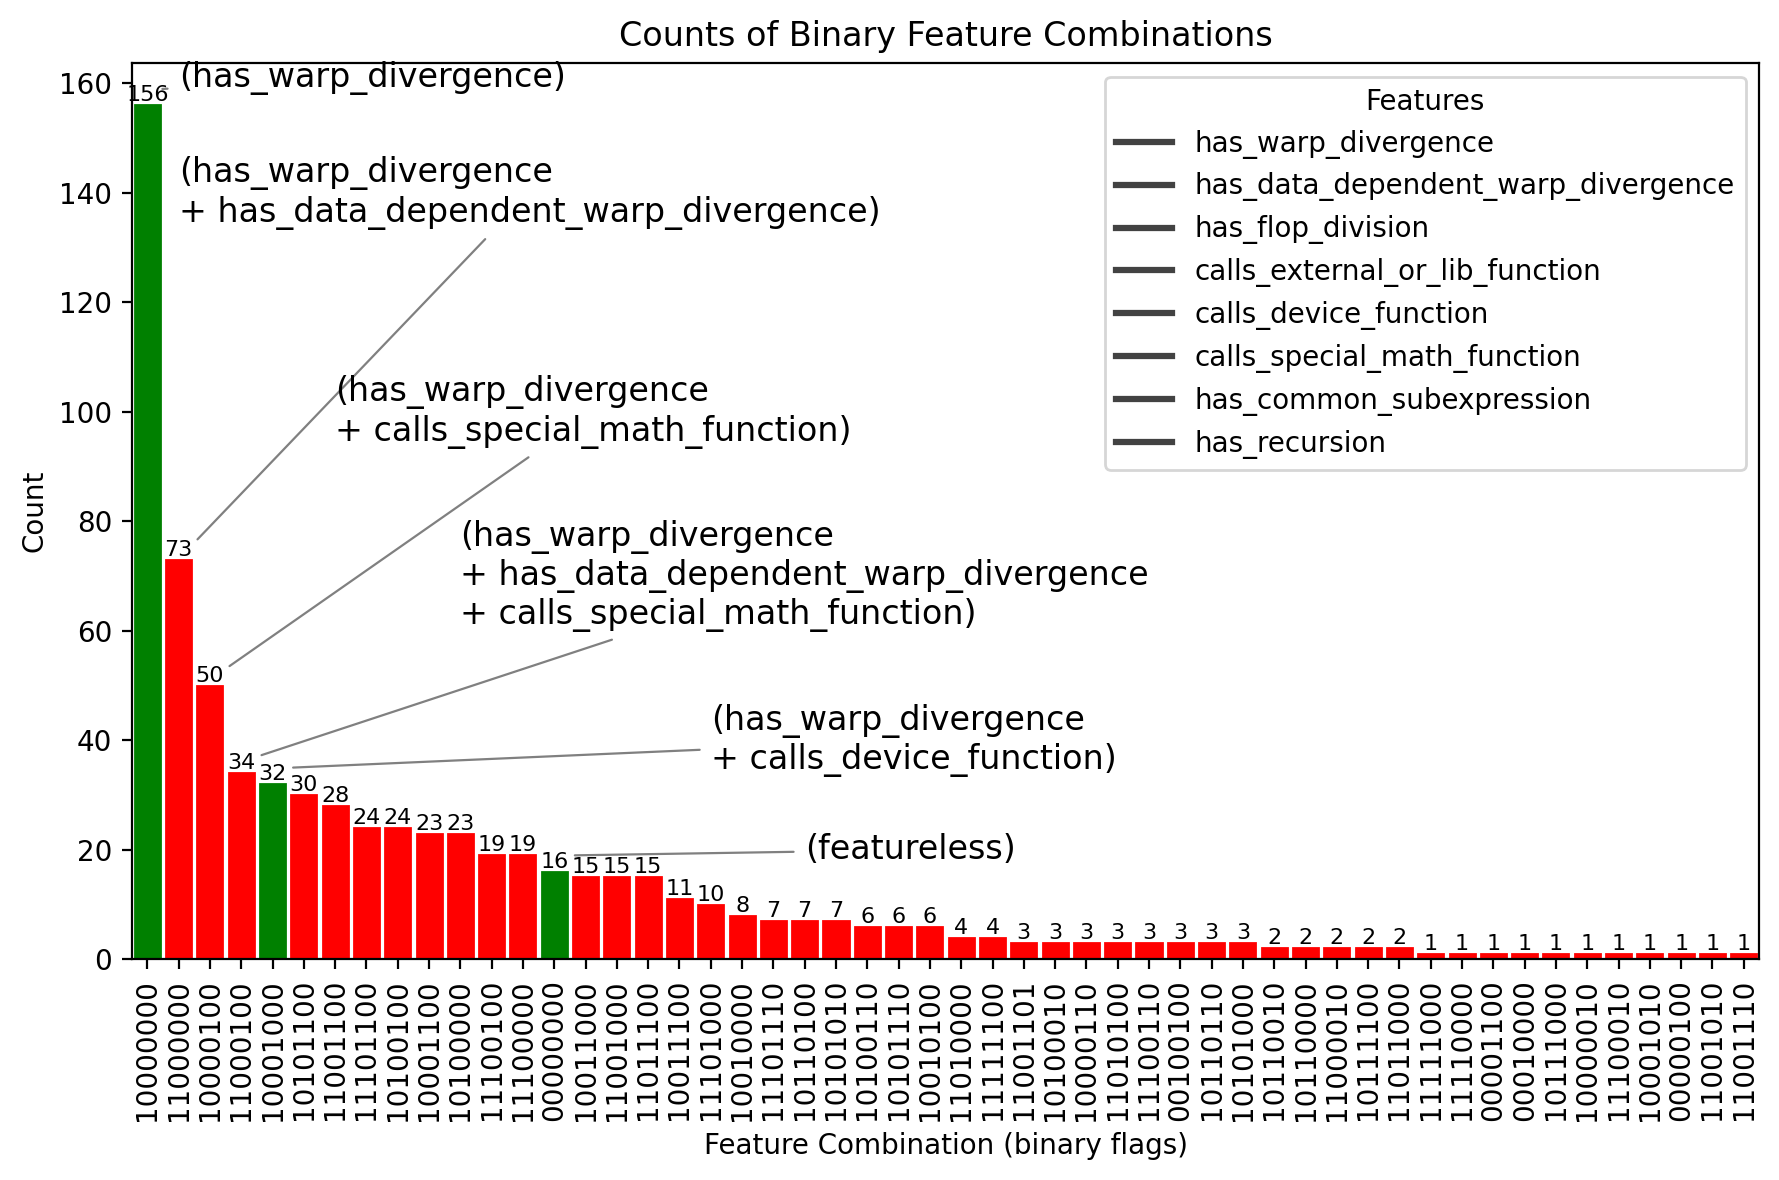

In [248]:

no_hidden_flop_combinations = ['10000000', '10001000', '00001000', '00000000']

df_grouped = manual_df.groupby(normalized_cols).size().reset_index(name='count')
df_grouped_sorted = df_grouped[df_grouped['count'] > 0].sort_values(by='count', ascending=False)

df_grouped_sorted['combination'] = df_grouped_sorted[normalized_cols].apply(
    lambda row: ''.join(row.astype(int).astype(str)), axis=1)

print(df_grouped_sorted.head(5))

plt.figure(figsize=(9, 6), dpi=200)
ax = sns.barplot(x='combination', y='count', data=df_grouped_sorted)
plt.title('Counts of Binary Feature Combinations')
plt.xlabel('Feature Combination (binary flags)')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='center')

# Annotate feature tuples (first four only) at right edge inside plot with arrows, and counts above bars
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# shift label_x slightly inside the right boundary
label_x = xlim[1] - (xlim[1] - xlim[0]) * 0.05
# define stagger offsets to prevent text overlap
stagger_offsets = [1, 1, 6, 10, 18, 21]  # stagger offsets for the first five bars

custom_text_heights = [158+3, 140, 100, 70, 40, 20]

for i, (p, (_, row)) in enumerate(zip(ax.patches, df_grouped_sorted.iterrows())):
    height = p.get_height()
    # set the bar color if the x-axis label (combination) is in no_hidden_flop_combinations
    if row['combination'] in no_hidden_flop_combinations:
        p.set_color('green')
    else:
        p.set_color('red')
    feature_names = [name for name, flag in zip(normalized_cols, row[normalized_cols]) if flag]
    tuple_text = f"({(chr(10)+'+ ').join(feature_names)})" if feature_names else '()'
    # draw arrow annotation for first five bars
    if i < 5 or row['combination'] == '00000000':
        if row['combination'] == '00000000':
            i = 5
            tuple_text = '(featureless)'

        ax.annotate(tuple_text,
                    xy=(p.get_x() + p.get_width()*1.1, height+3),
                    xytext=(stagger_offsets[i], custom_text_heights[i]),
                    ha='left', va='center', color='black', fontsize=12,
                    arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))
    # annotate count above bar
    ax.annotate(f"{int(height)}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', color='black', fontsize=8)


ax.legend(normalized_cols, title='Features')
plt.tight_layout()
plt.show()

In [249]:
# let's categorize the codes as being "easy" or "hard" to count FLOPs

#no_hidden_flop_combinations = ['10000000', '10001000', '00001000', '00000000']

manual_df['isEasy'] = manual_df['combination'].apply(lambda comb: comb in no_hidden_flop_combinations)

print(manual_df['isEasy'].value_counts())

isEasy
False    513
True     204
Name: count, dtype: int64


In [250]:
# let's check how many individual executables there are
print('targets with at least 1 hard-labelled kernel', manual_df[manual_df['isEasy'] == False]['targetName'].nunique())
print('targets with at least 1 easy-labelled kernel', manual_df[manual_df['isEasy'] == True]['targetName'].nunique())

targets with at least 1 hard-labelled kernel 222
targets with at least 1 easy-labelled kernel 95


## Extract the kernel names from the source codes

In [251]:
import sys
sys.path.append("..")  # Adjust the path to import from the parent directory

# Now let's cross-reference this list of easy kernels with the extracted_CUDA_kernels.json file
from utils.dataset import kernels_data  

from static_passes.TargetKernel import TargetKernel

#from tree_sitter import Language, Parser
#import tree_sitter_cuda
#
#CUDA_LANGUAGE = Language(tree_sitter_cuda.language())
#parser = Parser(CUDA_LANGUAGE)

In [252]:
hard_and_easy_codes = manual_df.copy()

hard_and_easy_codes['kernelName'] = ''

print(hard_and_easy_codes.columns)

Index(['targetName', 'filepath', 'kernel_index', '1: Has Warp Divergence',
       '2: Has Data-Dependent Warp Divergence', '3: Has FLOP Division',
       '4: Calls EXTERNAL or LIB function', '5: Calls DEVICE function',
       '6: Calls special math function', '7: Has Common Subexpression',
       '8: Has Recursion', '9: Missing Some Code', 'has_warp_divergence',
       'has_data_dependent_warp_divergence', 'has_flop_division',
       'calls_external_or_lib_function', 'calls_device_function',
       'calls_special_math_function', 'has_common_subexpression',
       'has_recursion', 'combination', 'isEasy', 'kernelName'],
      dtype='object')


In [253]:
# for each hard_code, get the corresponding source from the kernels_data object 

for index, row in hard_and_easy_codes.iterrows():
    target_name = row['targetName']
    filepath = row['filepath']
    kernel_index = row['kernel_index']

    # get the corresponding source code from kernels_data
    target_files_dict = kernels_data[target_name]
    kernels_list = target_files_dict[filepath]
    source_code = kernels_list[kernel_index]
    kernel_name = TargetKernel.get_global_func_name(source_code)

    hard_and_easy_codes.at[index,'kernelName'] = kernel_name

    #print(f"Target: {target_name}, File: {filepath}, Kernel Index: {kernel_index}, \n\tKernel Name: {kernel_name}\n\n")





In [254]:
hard_and_easy_codes['combined_name'] = '(' + hard_and_easy_codes['targetName'] + ', ' + hard_and_easy_codes['kernelName'] + ')'

print(hard_and_easy_codes['combined_name'].head())
print(hard_and_easy_codes['combined_name'].tail())

0                   (aligned-types-cuda, testKernel)
1           (particlefilter-cuda, kernel_likelihood)
2                  (particlefilter-cuda, kernel_sum)
3    (particlefilter-cuda, kernel_normalize_weights)
4           (particlefilter-cuda, kernel_find_index)
Name: combined_name, dtype: object
712         (backprop-cuda, kernel_layerforward)
713       (backprop-cuda, kernel_adjust_weights)
714    (multinomial-cuda, sampleMultinomialOnce)
715                       (score-cuda, findTopK)
716               (attentionMultiHead-cuda, mha)
Name: combined_name, dtype: object


## Load up the already-made datasets

We're going to add the classification columns to those codes and then visualize the distribution

In [255]:
hard_df = pd.read_csv('./hard_kernels_to_inference_unbalanced_with_compile_commands.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='"') 

easy_df = pd.read_csv('./kernels_to_inference_balanced_with_compile_commands.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='"')


In [256]:
# rename the NNZ_FLOP_STATE values to be more concise

renamed = {'Zero SP + DP FLOP' : 'No FLOP',
           'Non-zero SP FLOP' : 'SP-Only',
           'Non-zero DP FLOP' : 'DP-Only',
           'Non-zero SP + DP FLOP' : 'Mixed' }

easy_df['nnz_flop_state'] = easy_df['nnz_flop_state'].apply(lambda x: renamed[x])
hard_df['nnz_flop_state'] = hard_df['nnz_flop_state'].apply(lambda x: renamed[x])

In [257]:
print(hard_df.columns)
print(hard_df.shape)

print(easy_df.columns)
print(easy_df.shape)

Index(['Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName', 'language', 'combined_name',
       'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code', 'num_tokens',
       'compile_commands', 'variant'],
      dtype='object')
(373, 25)
Index(['Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName', 'language', 'combined_name',
       'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code', 'num_tokens',
       'compile_commands', 'variant'],
      dtype='object')
(204, 25)


## Join the `manual_df` to the easy and hard dfs

In [259]:
easy_joined = pd.merge(easy_df, hard_and_easy_codes, on='combined_name', how='left')
print(easy_joined.shape)
print(easy_joined.columns)

hard_joined = pd.merge(hard_df, hard_and_easy_codes, on='combined_name', how='left')
print(hard_joined.shape)
print(hard_joined.columns)

assert list(easy_joined.columns) == list(hard_joined.columns), "Columns do not match between easy and hard joined dataframes."
assert easy_joined['isEasy'].all(), "Not all rows in easy_joined are marked as easy."
assert not hard_joined['isEasy'].any(), "Some rows in hard_joined are incorrectly marked as easy."

easy_and_hard_joined = pd.concat([easy_joined, hard_joined], ignore_index=True)
print(easy_and_hard_joined.shape)
print(easy_and_hard_joined.columns)

(204, 48)
Index(['Kernel Name', 'targetName_x', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName_x', 'language',
       'combined_name', 'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code',
       'num_tokens', 'compile_commands', 'variant', 'targetName_y', 'filepath',
       'kernel_index', '1: Has Warp Divergence',
       '2: Has Data-Dependent Warp Divergence', '3: Has FLOP Division',
       '4: Calls EXTERNAL or LIB function', '5: Calls DEVICE function',
       '6: Calls special math function', '7: Has Common Subexpression',
       '8: Has Recursion', '9: Missing Some Code', 'has_warp_divergence',
       'has_data_dependent_warp_divergence', 'has_flop_division',
       'calls_external_or_lib_function', 'calls_device_function',
       'calls_special_math_function', 'has_common_subexpression',
       'has_recursion', 'combination', 'isEasy', 'kernelName_y'],
      dtype='o

## Tabularize all the easy/hard data -- counts for all the classes

In [157]:
def tabulate_each_nz_flop_type(input_df, prefix='Easy Subset'):
    nz_flop_types = list(input_df['nnz_flop_state'].unique())
    counts = dict()
    percents = dict()
    for nz_type in nz_flop_types: 
        subset = input_df[input_df['nnz_flop_state'] == nz_type]

        subset_counts = subset[original_cat_cols[:-1]].sum()
        subset_num_featureless = subset[subset.combination == '00000000']['combined_name'].count()
        subset_featureless = pd.Series([subset_num_featureless], index=['9: No Attributes'])
        subset_counts = pd.concat([subset_counts, subset_featureless])
        subset_percents = subset_counts*100 / subset.shape[0]

        print(f'{prefix} : {nz_type}')
        print(subset_counts)
        print(subset_percents)
        print()

        counts[nz_type] = subset_counts
        percents[nz_type] = subset_percents

    return counts, percents
    

# produce a LaTeX table with the same data as the tabulate_each_nz_flop_type
def tabulate_both_nz_flop_types(easy_df, hard_df):
    """
    Build a LaTeX table showing counts and percentages for each manual category (rows)
    across all combinations of nnz_flop_state and Easy/Hard datasets (columns).

    Table layout: first column = category labels (original_cat_cols[:-1] + '9: No Attributes'),
    subsequent columns in the order: for each nnz_flop_state (sorted), two columns: '{state} (Easy)' and '{state} (Hard)'.

    Each cell shows: count (xx.xx %). Percent is relative to the number of rows in that nnz_flop_state × dataset partition (i.e., among easy rows with that nnz state).
    If a particular state is missing from a partition, the cell is '0 (0.00 %)'.
    Returns the latex string and the pandas DataFrame used to format it.
    """
    # prepare row labels: categories 1..8 and featureless as '9: No Attributes'
    row_labels = list(original_cat_cols[:-1]) + ['9: No Attributes']

    # gather unique nnz states from both dataframes, stable sorted order
    nnz_states = sorted(list(pd.concat([easy_df['nnz_flop_state'], hard_df['nnz_flop_state']]).dropna().unique()))

    # build column MultiIndex labels: (state, Dataset) where Dataset in ['Easy','Hard']
    columns = []
    for state in nnz_states:
        columns.append((state, 'Easy'))
        columns.append((state, 'Hard'))

    # create an empty DataFrame to hold formatted cells as strings
    table_df = pd.DataFrame(index=row_labels, columns=pd.MultiIndex.from_tuples(columns))

    # helper to compute counts and percents for a given df (easy/hard) and state
    def compute_for_partition(df, state):
        # subset rows with the given state
        subset = df[df['nnz_flop_state'] == state]
        total = subset.shape[0]
        # counts for original categories
        counts = {}
        if total == 0:
            for cat in original_cat_cols[:-1]:
                counts[cat] = 0
            counts['9: No Attributes'] = 0
            return counts, total

        for cat in original_cat_cols[:-1]:
            if cat in subset.columns:
                counts[cat] = int(subset[subset[cat] == True].shape[0])
            else:
                counts[cat] = 0
        counts['9: No Attributes'] = int(subset[subset['combination'] == '00000000'].shape[0])
        return counts, total

    # populate table_df
    for state in nnz_states:
        # easy
        easy_counts, easy_total = compute_for_partition(easy_df, state)
        hard_counts, hard_total = compute_for_partition(hard_df, state)

        for row in row_labels:
            # easy cell
            cnt_e = easy_counts.get(row, 0)
            pct_e = (cnt_e * 100.0 / easy_total) if easy_total > 0 else 0.0
            table_df.loc[row, (state, 'Easy')] = f"{cnt_e} ({pct_e:0.2f} %)"
            # hard cell
            cnt_h = hard_counts.get(row, 0)
            pct_h = (cnt_h * 100.0 / hard_total) if hard_total > 0 else 0.0
            table_df.loc[row, (state, 'Hard')] = f"{cnt_h} ({pct_h:0.2f} %)"

    # build LaTeX table from table_df
    # column headers: combine state and dataset into single header like 'state\n(Easy)'
    col_headers = [f"{s}\\n({d})" for s, d in table_df.columns]

    # build latex manually for better control
    ncols = 1 + len(col_headers)
    col_spec = 'l' + 'c' * (ncols - 1)
    latex_lines = []
    latex_lines.append(r'\begin{table}[ht]')
    latex_lines.append(r'\centering')
    latex_lines.append(r'\begin{tabular}{{{'+col_spec+'}}}')
    latex_lines.append(r'\toprule')
    # header row
    header_row = ['Category'] + col_headers
    latex_lines.append(' & '.join(header_row) + ' \\')
    latex_lines.append('\midrule')

    for row_label in table_df.index:
        row_vals = [row_label] + [table_df.loc[row_label, col] for col in table_df.columns]
        latex_lines.append(' & '.join(row_vals) + ' \\')

    latex_lines.append(r'\bottomrule')
    latex_lines.append(r'\end{tabular}')
    latex_lines.append(r'\caption{Counts and percentages per category across nnzflopstate and dataset partitions. Percentages are relative to the partition size.}')
    latex_lines.append(r'\label{tab:nnz_flop_state_counts}')
    latex_lines.append(r'\end{table}')

    latex = '\n'.join(latex_lines)
    return latex, table_df


In [158]:
latex, table_df = tabulate_both_nz_flop_types(easy_joined, hard_joined)

print(latex)

\begin{table}[ht]
\centering
\begin{tabular}{{{lcccccccc}}}
\toprule
Category & DP-Only\n(Easy) & DP-Only\n(Hard) & Mixed\n(Easy) & Mixed\n(Hard) & No FLOP\n(Easy) & No FLOP\n(Hard) & SP-Only\n(Easy) & SP-Only\n(Hard) \
\midrule
1: Has Warp Divergence & 59 (89.39 %) & 25 (100.00 %) & 0 (0.00 %) & 50 (100.00 %) & 63 (87.50 %) & 151 (98.05 %) & 59 (89.39 %) & 141 (97.92 %) \
2: Has Data-Dependent Warp Divergence & 0 (0.00 %) & 14 (56.00 %) & 0 (0.00 %) & 27 (54.00 %) & 0 (0.00 %) & 84 (54.55 %) & 0 (0.00 %) & 66 (45.83 %) \
3: Has FLOP Division & 0 (0.00 %) & 10 (40.00 %) & 0 (0.00 %) & 48 (96.00 %) & 0 (0.00 %) & 3 (1.95 %) & 0 (0.00 %) & 77 (53.47 %) \
4: Calls EXTERNAL or LIB function & 0 (0.00 %) & 2 (8.00 %) & 0 (0.00 %) & 2 (4.00 %) & 0 (0.00 %) & 46 (29.87 %) & 0 (0.00 %) & 11 (7.64 %) \
5: Calls DEVICE function & 13 (19.70 %) & 10 (40.00 %) & 0 (0.00 %) & 23 (46.00 %) & 12 (16.67 %) & 73 (47.40 %) & 13 (19.70 %) & 68 (47.22 %) \
6: Calls special math function & 0 (0.00 %) & 14 (5

In [159]:
tabulate_each_nz_flop_type(easy_joined, 'Easy Subset')

Easy Subset : SP-Only
1: Has Warp Divergence                   59
2: Has Data-Dependent Warp Divergence     0
3: Has FLOP Division                      0
4: Calls EXTERNAL or LIB function         0
5: Calls DEVICE function                 13
6: Calls special math function            0
7: Has Common Subexpression               0
8: Has Recursion                          0
9: No Attributes                          7
dtype: int64
1: Has Warp Divergence                   89.393939
2: Has Data-Dependent Warp Divergence     0.000000
3: Has FLOP Division                      0.000000
4: Calls EXTERNAL or LIB function         0.000000
5: Calls DEVICE function                 19.696970
6: Calls special math function            0.000000
7: Has Common Subexpression               0.000000
8: Has Recursion                          0.000000
9: No Attributes                         10.606061
dtype: float64

Easy Subset : No FLOP
1: Has Warp Divergence                   63
2: Has Data-Dependent Warp D

({'SP-Only': 1: Has Warp Divergence                   59
  2: Has Data-Dependent Warp Divergence     0
  3: Has FLOP Division                      0
  4: Calls EXTERNAL or LIB function         0
  5: Calls DEVICE function                 13
  6: Calls special math function            0
  7: Has Common Subexpression               0
  8: Has Recursion                          0
  9: No Attributes                          7
  dtype: int64,
  'No FLOP': 1: Has Warp Divergence                   63
  2: Has Data-Dependent Warp Divergence     0
  3: Has FLOP Division                      0
  4: Calls EXTERNAL or LIB function         0
  5: Calls DEVICE function                 12
  6: Calls special math function            0
  7: Has Common Subexpression               0
  8: Has Recursion                          0
  9: No Attributes                          9
  dtype: int64,
  'DP-Only': 1: Has Warp Divergence                   59
  2: Has Data-Dependent Warp Divergence     0
  3: Has FLOP D

In [160]:
tabulate_each_nz_flop_type(hard_joined, 'Hard Subset')

Hard Subset : No FLOP
1: Has Warp Divergence                   151
2: Has Data-Dependent Warp Divergence     84
3: Has FLOP Division                       3
4: Calls EXTERNAL or LIB function         46
5: Calls DEVICE function                  73
6: Calls special math function            93
7: Has Common Subexpression                1
8: Has Recursion                           0
9: No Attributes                           0
dtype: int64
1: Has Warp Divergence                   98.051948
2: Has Data-Dependent Warp Divergence    54.545455
3: Has FLOP Division                      1.948052
4: Calls EXTERNAL or LIB function        29.870130
5: Calls DEVICE function                 47.402597
6: Calls special math function           60.389610
7: Has Common Subexpression               0.649351
8: Has Recursion                          0.000000
9: No Attributes                          0.000000
dtype: float64

Hard Subset : SP-Only
1: Has Warp Divergence                   141
2: Has Data-Depend

({'No FLOP': 1: Has Warp Divergence                   151
  2: Has Data-Dependent Warp Divergence     84
  3: Has FLOP Division                       3
  4: Calls EXTERNAL or LIB function         46
  5: Calls DEVICE function                  73
  6: Calls special math function            93
  7: Has Common Subexpression                1
  8: Has Recursion                           0
  9: No Attributes                           0
  dtype: int64,
  'SP-Only': 1: Has Warp Divergence                   141
  2: Has Data-Dependent Warp Divergence     66
  3: Has FLOP Division                      77
  4: Calls EXTERNAL or LIB function         11
  5: Calls DEVICE function                  68
  6: Calls special math function           105
  7: Has Common Subexpression               14
  8: Has Recursion                           0
  9: No Attributes                           0
  dtype: int64,
  'DP-Only': 1: Has Warp Divergence                   25
  2: Has Data-Dependent Warp Divergence    

In [161]:
# Build a combined Sankey: Easy and Hard in the center, split to partition-specific nnz nodes,
# then both partitions link to shared category nodes (categories are common/shared after the nnz split).
import plotly.graph_objects as go

def make_combined_sankey(easy_df, hard_df, title='Easy <-> nnz_flop_state -> Shared Categories'):

    easy_df = easy_df.copy()
    hard_df = hard_df.copy()

    #rename the nnz_flop_state
    #renamed = {'Zero SP + DP FLOP' : 'No FLOPs',
    #           'Non-zero SP FLOP' : 'SP-only',
    #           'Non-zero DP FLOP' : 'DP-only',
    #           'Non-zero SP + DP FLOP' : 'Mixed'
    #           }
    #easy_df['nnz_flop_state'] = easy_df['nnz_flop_state'].apply(lambda x: renamed[x])
    #hard_df['nnz_flop_state'] = hard_df['nnz_flop_state'].apply(lambda x: renamed[x])

    # center nodes
    center_nodes = ['Easy', 'Hard']

    # partition-specific nnz nodes (prefix to avoid collisions)
    easy_nnz = sorted(list(easy_df['nnz_flop_state'].dropna().unique()))
    easy_nnz_nodes = [f"E: {s}" for s in easy_nnz]

    hard_nnz = sorted(list(hard_df['nnz_flop_state'].dropna().unique()))
    hard_nnz_nodes = [f"H: {s}" for s in hard_nnz]

    # shared category nodes (original categories 1..8) + '9: No Attributes'
    category_nodes = original_cat_cols[:-1].copy() + ['9: No Attributes']

    # node ordering: easy nnz (left), center (Easy/Hard), hard nnz (right-of-center), categories (far right)
    node_labels = easy_nnz_nodes + center_nodes + hard_nnz_nodes + category_nodes
    label_to_idx = {lbl: i for i, lbl in enumerate(node_labels)}

    sources = []
    targets = []
    values = []

    # Center -> partition nnz links
    for state in easy_nnz:
        cnt = int(easy_df[easy_df['nnz_flop_state'] == state].shape[0])
        if cnt > 0:
            sources.append(label_to_idx['Easy'])
            targets.append(label_to_idx[f"E: {state}"])
            values.append(cnt)

    for state in hard_nnz:
        cnt = int(hard_df[hard_df['nnz_flop_state'] == state].shape[0])
        if cnt > 0:
            sources.append(label_to_idx['Hard'])
            targets.append(label_to_idx[f"H: {state}"])
            values.append(cnt)

    # Partition nnz -> shared categories
    # Easy partition
    for state in easy_nnz:
        subset = easy_df[easy_df['nnz_flop_state'] == state]
        for orig_cat in original_cat_cols[:-1]:
            if orig_cat not in subset.columns:
                continue
            cnt = int(subset[subset[orig_cat] == True].shape[0])
            if cnt > 0:
                sources.append(label_to_idx[f"E: {state}"])
                targets.append(label_to_idx[orig_cat])
                values.append(cnt)
        feat_cnt = int(subset[subset['combination'] == '00000000'].shape[0])
        if feat_cnt > 0:
            sources.append(label_to_idx[f"E: {state}"])
            targets.append(label_to_idx['9: No Attributes'])
            values.append(feat_cnt)

    # Hard partition
    for state in hard_nnz:
        subset = hard_df[hard_df['nnz_flop_state'] == state]
        for orig_cat in original_cat_cols[:-1]:
            if orig_cat not in subset.columns:
                continue
            cnt = int(subset[subset[orig_cat] == True].shape[0])
            if cnt > 0:
                sources.append(label_to_idx[f"H: {state}"])
                targets.append(label_to_idx[orig_cat])
                values.append(cnt)
        feat_cnt = int(subset[subset['combination'] == '00000000'].shape[0])
        if feat_cnt > 0:
            sources.append(label_to_idx[f"H: {state}"])
            targets.append(label_to_idx['9: No Attributes'])
            values.append(feat_cnt)

    # create sankey figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(label=node_labels, pad=8, thickness=15, line=dict(color='black', width=0.5)),
        link=dict(source=sources, target=targets, value=values)
    )])
    fig.update_layout(title_text=title, font_size=11, width=800, height=500)
    return fig

# Generate and show the combined Sankey if both datasets are present
if 'easy_joined' in globals() and 'hard_joined' in globals():
    fig_combined = make_combined_sankey(easy_joined, hard_joined)
    fig_combined.show()
else:
    print('Both easy_joined and hard_joined must be present in the notebook globals to build the combined Sankey.')

In [162]:
# create a pie chart of the easy vs hard kernels, showing percentages of each

In [163]:
# manually check a lulesh code

lulesh_sample = hard_joined[hard_joined['combined_name'] == '(lulesh-cuda, calcKinematicsForElems)']

lulesh_sample

,Kernel Name,targetName_x,exeArgs,traffic,dpAI,spAI,dpPerf,spPerf,xtime,Block Size,...,has_data_dependent_warp_divergence,has_flop_division,calls_external_or_lib_function,calls_device_function,calls_special_math_function,has_common_subexpression,has_recursion,combination,isEasy,kernelName_y
64,"calcKinematicsForElems(const double *, const d...",lulesh-cuda,-i 100 -s 128 -r 11 -b 1 -c 1,7.642400e+10,2.972302,0.024471,2.271552e+11,1.870182e+09,4477600.0,"(256, 1, 1)",...,False,True,False,True,False,True,False,10101010,False,calcKinematicsForElems


In [164]:
# print the distribution across the 1-8 columns
print(original_cat_cols)

easy_counts = easy_joined[original_cat_cols[:-1]].sum()
easy_num_featureless = easy_joined[easy_joined.combination == '00000000']['combined_name'].count()
easy_featureless = pd.Series([easy_num_featureless], index=['9: No Attributes'])
easy_counts = pd.concat([easy_counts, easy_featureless])
easy_percents = easy_counts*100 / easy_joined.shape[0]

print('Easy Subset')
print(easy_counts)
print(easy_percents)
print()

hard_counts = hard_joined[original_cat_cols[:-1]].sum()
hard_num_featureless = hard_joined[hard_joined.combination == '00000000']['combined_name'].count()
hard_featureless = pd.Series([hard_num_featureless], index=['9: No Attributes'])
hard_counts = pd.concat([hard_counts, hard_featureless])
hard_percents = hard_counts*100 / hard_joined.shape[0]

print('Hard Subset')
print(hard_counts)
print(hard_percents)
print()


['1: Has Warp Divergence', '2: Has Data-Dependent Warp Divergence', '3: Has FLOP Division', '4: Calls EXTERNAL or LIB function', '5: Calls DEVICE function', '6: Calls special math function', '7: Has Common Subexpression', '8: Has Recursion', '9: Missing Some Code']
Easy Subset
1: Has Warp Divergence                   181
2: Has Data-Dependent Warp Divergence      0
3: Has FLOP Division                       0
4: Calls EXTERNAL or LIB function          0
5: Calls DEVICE function                  38
6: Calls special math function             0
7: Has Common Subexpression                0
8: Has Recursion                           0
9: No Attributes                          23
dtype: int64
1: Has Warp Divergence                   88.725490
2: Has Data-Dependent Warp Divergence     0.000000
3: Has FLOP Division                      0.000000
4: Calls EXTERNAL or LIB function         0.000000
5: Calls DEVICE function                 18.627451
6: Calls special math function            0.00000

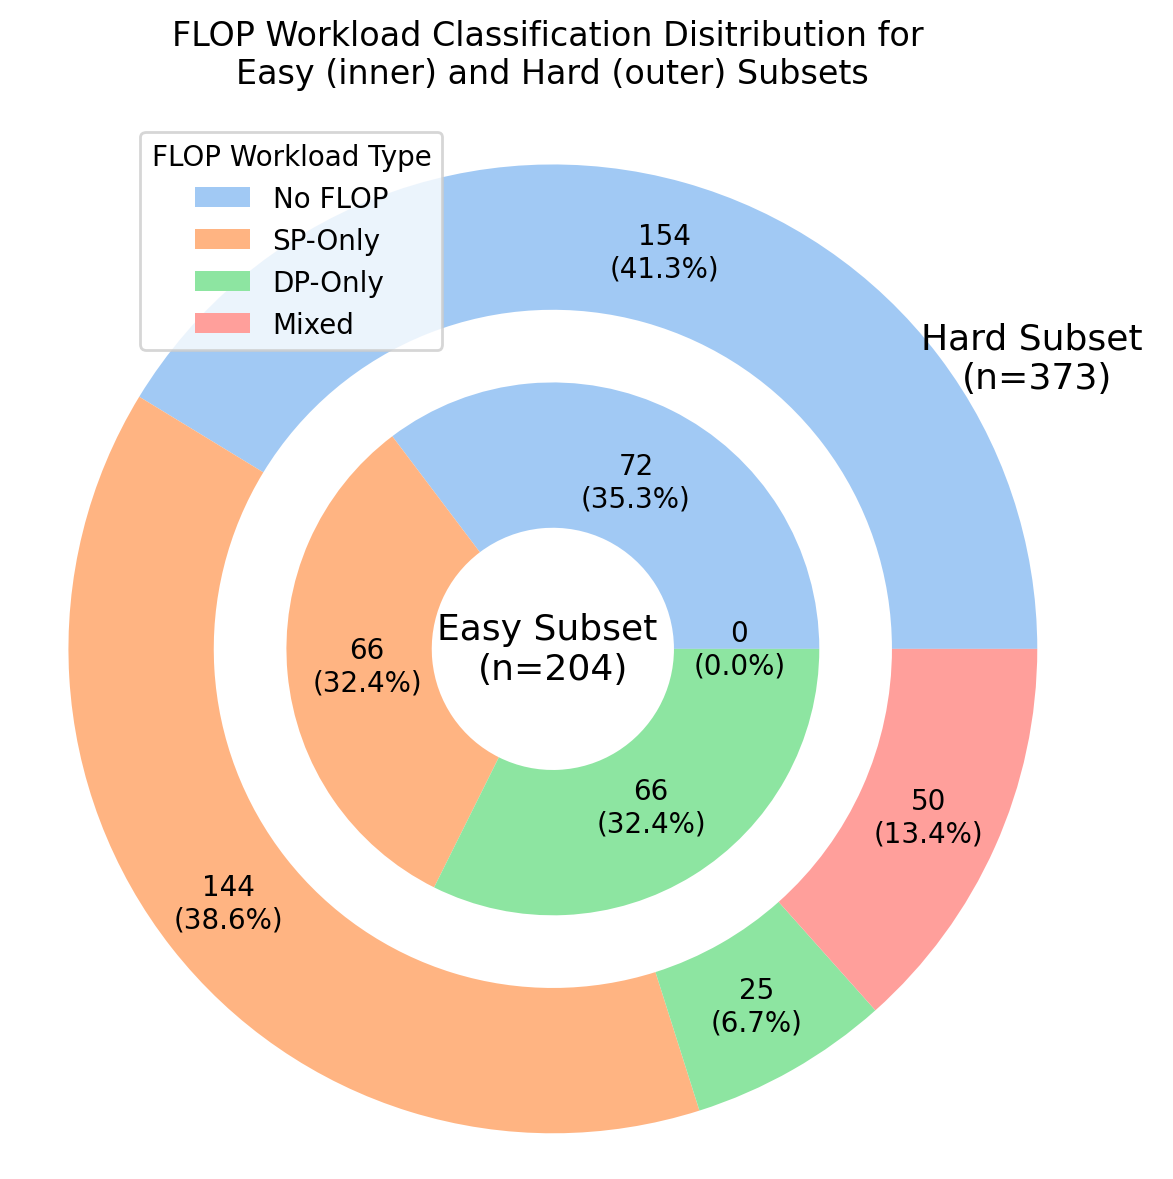

Easy distribution (counts):
nnz_flop_state
No FLOP    72
SP-Only    66
DP-Only    66
Name: count, dtype: int64

Hard distribution (counts):
nnz_flop_state
No FLOP    154
SP-Only    144
Mixed       50
DP-Only     25
Name: count, dtype: int64


In [241]:
# Compute distributions (value_counts) for easy/hard partitions (by nnz_flop_state)
easy_distrib = easy_joined['nnz_flop_state'].value_counts()
hard_distrib = hard_joined['nnz_flop_state'].value_counts()

# Build a single figure with two pie charts side-by-side (Easy | Hard).
# Each slice will display the raw count and the percentage of its partition.
import matplotlib.pyplot as plt

# Ensure both pies use the same category ordering (union of categories) so slices align visually
#all_categories = list(sorted(set(easy_distrib.index.tolist() + hard_distrib.index.tolist())))
all_categories = ['No FLOP', 'SP-Only', 'DP-Only', 'Mixed']
easy_counts = [int(easy_distrib.get(cat, 0)) for cat in all_categories]
hard_counts = [int(hard_distrib.get(cat, 0)) for cat in all_categories]

# Helper to show both count and percentage in the pie slice labels
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        # compute the absolute count for this slice (rounded)
        val = int(round(pct * total / 100.0))
        return f"{val}\n({pct:.1f}%)"
    return my_autopct

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
size = 0.3

# Easy pie
if sum(easy_counts) > 0:
    ax.pie(easy_counts, radius=1-1.5*size, labels=None, autopct=make_autopct(easy_counts), startangle=0, pctdistance=0.7, wedgeprops=dict(width=size), colors=sns.color_palette('pastel'))
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center')

# Hard pie
if sum(hard_counts) > 0:
    ax.pie(hard_counts, radius=1, labels=None, autopct=make_autopct(hard_counts), startangle=0, pctdistance=0.85, wedgeprops=dict(width=size), colors=sns.color_palette('pastel'))
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center')

ax.set_title(f'FLOP Workload Classification Disitribution for \nEasy (inner) and Hard (outer) Subsets', pad=20)
ax.axis('equal')

ax.legend(all_categories, title='FLOP Workload Type', loc='center left', bbox_to_anchor=(0.1, 0.9))

# add an axis annotation for Easy and Hard
ax.annotate(f'Easy Subset \n(n={sum(easy_counts)})', xy=(0, -1.0), xytext=(0,0),
            ha='center', va='center', fontsize=13,
            arrowprops=None)
ax.annotate(f'Hard Subset \n(n={sum(hard_counts)})', xy=(0, -1.0), xytext=(1.0, 0.6),
            ha='center', va='center', fontsize=13,
            arrowprops=None)

plt.tight_layout()
plt.show()

# Also print the raw distributions for quick debugging/inspection
print('Easy distribution (counts):')
print(easy_distrib)

print()
print('Hard distribution (counts):')
print(hard_distrib)

## Save the Dataframe to use later in SQL Results Visualization

In [260]:
easy_and_hard_joined.to_csv('gpuFLOPBench.csv', index=False, quoting=csv.QUOTE_NONNUMERIC, quotechar='"')

In [261]:
print(easy_and_hard_joined['nnz_flop_state'].value_counts())

nnz_flop_state
No FLOP    226
SP-Only    210
DP-Only     91
Mixed       50
Name: count, dtype: int64
